In [160]:
import sys
import os
sys.path.append("../..")

In [161]:
# import libraries and custom modules
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import survival.utils
importlib.reload(survival.utils)
from survival.utils import show_all



In [162]:
# load data
data = pd.read_parquet("../../data/processed/raw_clean.parquet")
hh = pd.read_csv("../../data/processed/hh_clean.csv")

In [163]:
# find the earliest purchase date per performance, in case people bought multiple tickets at different times
min_purchase_date = data.groupby(['id', 'start_date']).agg(
    min_purchase_date =( 'purchase_date', 'min')).reset_index()

data = data.merge(min_purchase_date, on=['id', 'start_date'], how='left')

In [164]:
# per id per start_date, count the amount of tickets bought and store in column 'order_size', and count per ticket type the amount of tickets bought and store in columns 'order_size_<ticket_type>'. fill with 0 if no tickets bought
data['order_size'] = data.groupby(['id', 'start_date'])['id'].transform('count')
data['total_order_value'] = data.groupby(['id', 'start_date'])['price'].transform('sum')
data['avg_order_value'] = data.groupby(['id', 'start_date'])['price'].transform('mean')
data['total_order_value'] = data['total_order_value'].round(2)
data['avg_order_value'] = data['avg_order_value'].round(2)

In [165]:
# drop these, but perhaps drop ticket_num earlier -> figure out if its necessary in a grouping operation
data = data.drop(columns=['ticket_num', 'price'])

In [166]:
data

,is_institutional,rank,country,email,municipality,city,production,season,purchase_date,start_date,...,is_free,artform,gender,birthdate,age,id,min_purchase_date,order_size,total_order_value,avg_order_value
0,1,rang 1,nl,joostplomp@xs4all.nl,waadhoeke,oudebildtzijl,21/22 raymonda,2021_2022,2021-11-02,2022-04-10 14:00:00,...,0,ballet,male,NaT,NaN,0037q000007bfcjqac,2021-11-02,3,180.0,60.0
1,1,rang 4,nl,joopvanderstraaten@planet.nl,lingewaard,gendt,22/23 carmen,2022_2023,2022-04-12,2022-09-18 14:00:00,...,0,opera,male,1943-05-02,81.0,0037q00000boc0mqax,2022-04-12,1,86.0,86.0
2,1,rang 2,nl,diepvriesconijn@quicknet.nl,wormerland,wormer,22/23 the sleeping beauty,2022_2023,2022-05-31,2022-10-29 19:30:00,...,0,ballet,female,1967-02-07,57.0,0037q00000bnum0qah,2022-05-31,10,650.0,65.0
3,1,rang 1,nl,gier@kpnmail.nl,breda,breda,22/23 konigskinder,2022_2023,2022-04-21,2022-10-09 14:00:00,...,0,opera,male,1951-08-22,73.0,0037q000007b11eqac,2022-04-21,1,123.0,123.0
4,1,rang 3,nl,jvbelkum@xs4all.nl,amersfoort,amersfoort,22/23 messa da requiem,2022_2023,2022-04-04,2023-02-19 14:00:00,...,0,opera,male,1937-12-08,86.0,0037q00000bojphqa5,2022-04-04,3,225.0,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732627,1,rang 3,nl,carollychia@gmail.com,utrecht,utrecht,24/25 jewels,2024_2025,2024-12-02,2025-02-16 14:00:00,...,0,ballet,female,1973-02-14,51.0,0037q00000qcsdqqam,2024-12-02,2,88.0,44.0
1732628,1,rang 2,nl,hanqingzhou@foxmail.com,den haag,'s-gravenhage,24/25 die fledermaus,2024_2025,2024-12-02,2024-12-10 19:30:00,...,0,opera,male,1997-05-20,27.0,0037q000007cvwaqao,2024-12-02,2,308.0,154.0
1732629,1,rang 2,nl,hanqingzhou@foxmail.com,den haag,'s-gravenhage,24/25 die fledermaus,2024_2025,2024-12-02,2024-12-10 19:30:00,...,0,opera,male,1997-05-20,27.0,0037q000007cvwaqao,2024-12-02,2,308.0,154.0
1732630,1,rang 1,ca,don@blueskier.com,None,toronto,24/25 lady macbeth,2024_2025,2024-12-02,2025-04-15 20:15:00,...,0,ballet,male,1937-07-12,87.0,003qs00000id4hoiar,2024-12-02,2,144.0,72.0


In [167]:
daily_sales = data.groupby(['start_date', 'purchase_date']).size().reset_index(name='tickets_sold')
    
# Calculate cumulative sales for each performance
result = daily_sales.sort_values(['start_date', 'purchase_date'])
result['cumulative_sales'] = result.groupby('start_date')['tickets_sold'].cumsum()

result = result[[
    'start_date',
    'purchase_date',
    'tickets_sold',
    'cumulative_sales'
]]

In [168]:
data = data.merge(result, on=['start_date', 'purchase_date'], how='left').drop(columns=['purchase_date'])


In [169]:
#remove subscription tickets
subscription_ticket = ['abo standaard', 'abo vk dno', 'abonnement 22/23', 'kassa abo standaard', 'abonnement 24/25', 'abo vk hnb', 'abo vrij']

# remove all subscription tickets from activity
data = data[~data['ticket_type'].isin(subscription_ticket)]

In [170]:
# delete records where is_free == 1 and drop the column
data = data[data['is_free'] != 1]
data = data.drop('is_free', axis=1)

In [171]:
# drop all educatie tickets because these visitors are not unique
data = data[~data['ticket_type'].str.contains('educatie')]

# drop all ticket where ticket_type are related to employees
employee_ticket = [
    'zoekplaats',
    'huiskorting',
    'medewerker',
    'medewerker no&b',
    'vrijplaats',
    'paniek',
    'balletorkest',
    'orkest',
    'nedpho'
    ]

data = data[~data['ticket_type'].isin(employee_ticket)]

# drop the following ids because they are related to employees, institutions or groups
nonvisitor_ids = [
    '0037q00000d5gxkqar',
    '0037q00000d5gxlqar',
    '0037q00000d5johqab',
    '0037q000007cqjkqa0',
    '0037q000007lgwlqa4',
    '0037q00000d5tlwqaz',
    '0037q00000boorlqa5',
    '0037q00000bnnfiqat',
    '0037q00000cmwoyqa0',
    '0037q00000boj2xqah',
    '0037q000007cxowqao',
    '0037q00000bnidzqap',
    '0037q00000boob7qap',
    '0037q00000d5johqab',
    '0037q00000boorsqap',
    '0037q00000kgdkzqav',
    '0037q00000boossqa5',
    '0037q00000d5zabqa3',
    '0037q00000boormqa5',
    '0037q00000booxsqa5',
    '0037q00000bool8qap',
    '0037q00000dmjviqa1',
    '0037q00000kgdwpqaf'
]

data = data[~data['id'].isin(nonvisitor_ids)]

In [172]:
data = data.join(
    data.groupby(['id', 'start_date', 'ticket_type'])
    .size()
    .unstack(fill_value=0)
    .add_prefix('tickets_type_'), 
    on=['id', 'start_date']
)

In [173]:
# drop ticket_type column
data = data.drop(columns='ticket_type')

# group by id and start_date and remove duplicates
data = data.drop_duplicates(subset=['id', 'start_date'])

In [174]:
data = data[data['total_order_value'] > 0]

In [175]:
data = pd.get_dummies(data, columns=['season'], dtype=int)

In [176]:
# map opera and ballet
data['artform'] = data['artform'].map({'opera': 1, 'ballet': 0})

In [177]:
data = data.reset_index(drop=True)
data

,is_institutional,rank,country,email,municipality,city,production,start_date,artform,gender,...,tickets_type_zorgmedewerker,season_2015_2016,season_2016_2017,season_2017_2018,season_2018_2019,season_2019_2020,season_2021_2022,season_2022_2023,season_2023_2024,season_2024_2025
0,1,rang 1,nl,joostplomp@xs4all.nl,waadhoeke,oudebildtzijl,21/22 raymonda,2022-04-10 14:00:00,0,male,...,0,0,0,0,0,0,1,0,0,0
1,1,rang 2,nl,diepvriesconijn@quicknet.nl,wormerland,wormer,22/23 the sleeping beauty,2022-10-29 19:30:00,0,female,...,0,0,0,0,0,0,0,1,0,0
2,1,premium,nl,anoukmeijvogel@hotmail.com,katwijk,katwijk zh,21/22 hans van manen festival,2022-06-15 20:15:00,0,unknown,...,0,0,0,0,0,0,1,0,0,0
3,1,rang 1,nl,angela_ridwan@yahoo.com,amsterdam,amsterdam,21/22 raymonda,2022-04-14 20:00:00,0,female,...,0,0,0,0,0,0,1,0,0,0
4,1,premium,nl,matthijs.driedonks@gmail.com,gooise meren,bussum,21/22 hans van manen festival,2022-06-15 20:15:00,0,unknown,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538024,1,rang 1,nl,irma.tomey@xs4all.nl,den haag,'s-gravenhage,24/25 jewels,2025-03-08 20:15:00,0,female,...,0,0,0,0,0,0,0,0,0,1
538025,1,rang 4,nl,vannijkerken@hotmail.com,winterswijk,winterswijk,24/25 jewels,2025-03-02 14:00:00,0,unknown,...,0,0,0,0,0,0,0,0,0,1
538026,1,rang 3,nl,carollychia@gmail.com,utrecht,utrecht,24/25 jewels,2025-02-16 14:00:00,0,female,...,0,0,0,0,0,0,0,0,0,1
538027,1,rang 2,nl,hanqingzhou@foxmail.com,den haag,'s-gravenhage,24/25 die fledermaus,2024-12-10 19:30:00,1,male,...,0,0,0,0,0,0,0,0,0,1


In [178]:
# sort data by id and min_purchase_date'])
data = data.sort_values(by=['id', 'min_purchase_date'])

# group by id and get the first 5 min_purchase_date']) values
data = data.groupby('id').head(5)

# Create a column for the purchase number
data['purchase_number'] = data.groupby('id').cumcount() + 1

# Pivot the data to get each purchase's order value as a separate column
pivot_data_avg_order_value = data.pivot(index='id', columns='purchase_number', values='avg_order_value')
pivot_data_total_order_value = data.pivot(index='id', columns='purchase_number', values='total_order_value')

# rename the columns for clarity
pivot_data_avg_order_value.columns = [f'avg_order_value_{col}' for col in pivot_data_avg_order_value.columns]
pivot_data_total_order_value.columns = [f'total_order_value_{col}' for col in pivot_data_total_order_value.columns]

# Merge back with the original data if you need to keep other columns
data = data.merge(pivot_data_avg_order_value, on='id', how='left')
data = data.merge(pivot_data_total_order_value, on='id', how='left')





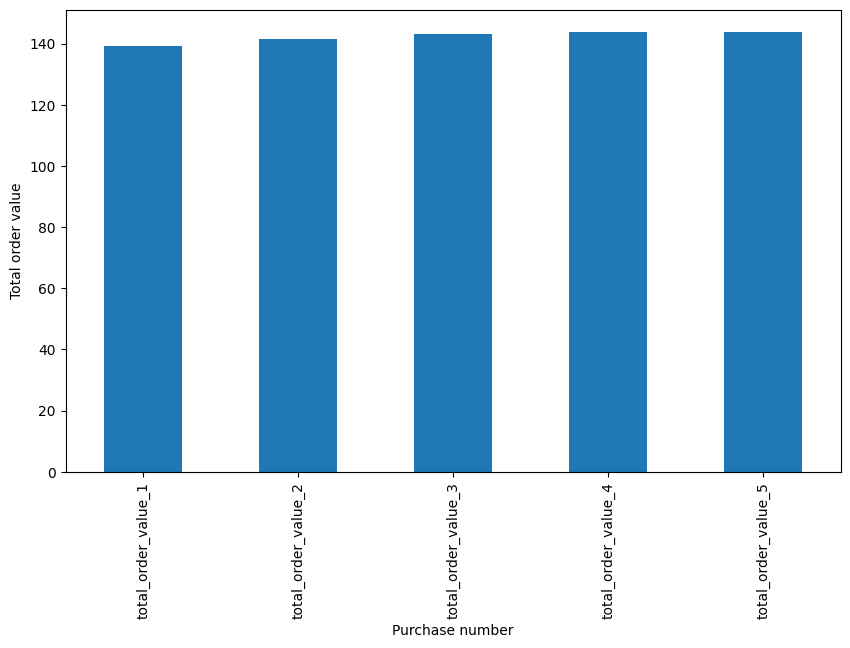

In [180]:
# create bar plot, with bar one representing the avg balue of avg_order_value_1, bar two representing the avg value of avg_order_value_2, etc.
fig, ax = plt.subplots(figsize=(10, 6))
data.filter(like='total_order_value_').mean().plot(kind='bar', ax=ax)
ax.set_ylabel('Total order value')
ax.set_xlabel('Purchase number')
plt.show()


In [ ]:
# check if the averages are statistically different
from scipy.stats import ttest_ind

# create a list to store the p-values
p_values = []

# loop through the columns and perform a t-test


In [157]:
data

,is_institutional,rank,country,email,municipality,city,production,start_date,artform,gender,...,season_2021_2022,season_2022_2023,season_2023_2024,season_2024_2025,purchase_number,avg_order_value_1,avg_order_value_2,avg_order_value_3,avg_order_value_4,avg_order_value_5
0,1,rang 1,nl,ljjschuurmans@gmail.com,delft,delft,22/23 turandot,2022-12-12 20:00:00,1,unknown,...,0,1,0,0,1,166.0,100.0,NaN,NaN,NaN
1,1,rang 2,nl,ljjschuurmans@gmail.com,delft,delft,22/23 messa da requiem,2023-02-13 20:15:00,1,unknown,...,0,1,0,0,2,166.0,100.0,NaN,NaN,NaN
2,1,rang 1,nl,r.bernelotmoens@operaballet.nl,bloemendaal,bloemendaal,17/18 mata hari,2017-10-21 20:15:00,0,female,...,0,0,0,0,1,15.0,18.0,107.33,18.0,20.0
3,1,rang 3,nl,r.bernelotmoens@operaballet.nl,bloemendaal,bloemendaal,17/18 la boheme,2017-12-26 14:00:00,1,female,...,0,0,0,0,2,15.0,18.0,107.33,18.0,20.0
4,1,rang 2,nl,r.bernelotmoens@operaballet.nl,bloemendaal,bloemendaal,17/18 la boheme,2017-12-16 20:00:00,1,female,...,0,0,0,0,3,15.0,18.0,107.33,18.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428591,1,rang 2,nl,f_duursema@hotmail.com,None,amsterdam,24/25 idomeneo,2025-02-15 19:30:00,1,unknown,...,0,0,0,1,1,169.0,NaN,NaN,NaN,NaN
428592,1,rang 1,nl,None,None,heemstede,24/25 die fledermaus,2024-12-25 14:00:00,1,female,...,0,0,0,1,1,178.0,NaN,NaN,NaN,NaN
428593,1,rang 4,nl,mirna@upcmail.nl,None,weesp,24/25 die fledermaus,2024-12-10 19:30:00,1,unknown,...,0,0,0,1,1,98.0,NaN,NaN,NaN,NaN
428594,1,rang 2,unknown,jonathanebrito@gmail.com,None,None,24/25 notenkraker en muizenkoning,2024-12-28 14:00:00,0,None,...,0,0,0,1,1,15.0,NaN,NaN,NaN,NaN


In [ ]:
# create a bar plot with per bar the average order value per purchase number



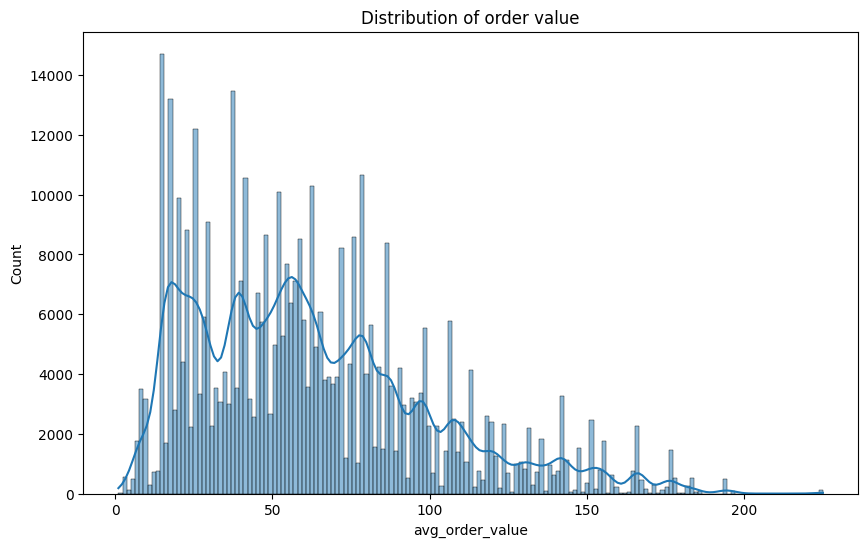

In [156]:
plt.figure(figsize=(10, 6))
sns.histplot(data['avg_order_value'], kde=True)
plt.title('Distribution of order value')
plt.show()

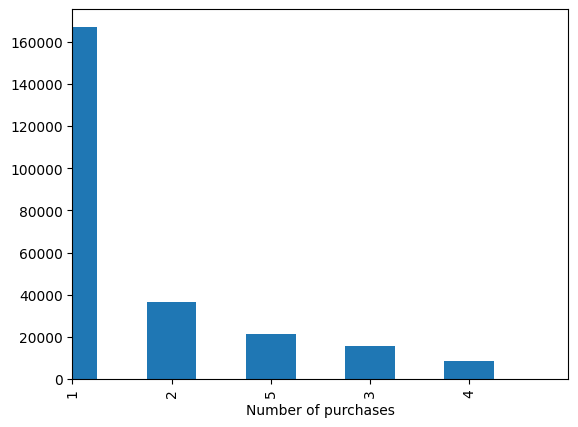

In [136]:
data['id'].value_counts().value_counts().plot(kind='bar')
plt.xlim(0,5)
plt.xlabel('Number of purchases')
plt.show()

In [ ]:
# add lead days feature
data['lead_days'] = (data['start_date'] - data['purchase_date']).dt.days

# retain only lead days that are 0 or above
data = data[data['lead_days'] >= 0]

In [ ]:
# age at time of purchase
data['age_at_purchase'] = (data['purchase_date'] - data['birthdate']).dt.days / 365.25
data['age_at_purchase'] = data['age_at_purchase'].apply(np.floor)
